The dataset contains transaction data of an online retailer store in Dec, 2010 to Dec, 2011.   
Many customers of the company are wholesalers

Objective: Provide insights to Business Team regarding the sales in the metioned period

[Dataset link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

In [ ]:
from pprint import pprint

from matplotlib import pyplot as plt
from matplotlib import style as matplotlib_style
matplotlib_style.use("ggplot")
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 30)
import seaborn as sns

from IPython.display import display

In [2]:
df = pd.read_csv(
    "dataset/uk_retailer.csv", 
    encoding="unicode_escape", 
    date_format="%m/%d/%Y %H:%M", 
    parse_dates=["InvoiceDate"], 
    dtype={
        "InvoiceNo": pd.StringDtype(),
        "StockCode": pd.StringDtype(),
        "Description": pd.StringDtype(),
        "Quantity": pd.Int16Dtype(),
        "UnitPrice": pd.Float64Dtype(),
        "CustomerID": pd.StringDtype(),
        "Country": pd.StringDtype()
    }
)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
df = df.rename(columns={"InvoiceDate": "InvoiceTimestamp"})

df["InvoiceDate"] = df["InvoiceTimestamp"].dt.date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d")

df.dtypes

InvoiceNo           string[python]
StockCode           string[python]
Description         string[python]
Quantity                     Int16
InvoiceTimestamp    datetime64[ns]
UnitPrice                  Float64
CustomerID          string[python]
Country             string[python]
InvoiceDate         datetime64[ns]
dtype: object

In [4]:
df["year_month"] = df["InvoiceDate"].dt.strftime('%Y-%m')
df = df.sort_values(by="year_month", ascending=True)

In [5]:
# preserve original df
df_ = df.copy()

# Data Cleaning

In [6]:
display(
    df.describe(exclude=[pd.StringDtype()]),
    df.describe(include=[pd.StringDtype()])
)

,Quantity,InvoiceTimestamp,UnitPrice,InvoiceDate,year_month
count,541909.0,541909,541909.0,541909,541909
unique,<NA>,NaN,<NA>,NaN,13
top,<NA>,NaN,<NA>,NaN,2011-11
freq,<NA>,NaN,<NA>,NaN,84711
mean,9.55225,2011-07-04 13:34:57.156385792,4.611114,2011-07-04 00:00:13.073781760,NaN
min,-15459.0,2010-12-01 08:26:00,-11062.06,2010-12-01 00:00:00,NaN
25%,1.0,2011-03-28 11:34:00,1.25,2011-03-28 00:00:00,NaN
50%,3.0,2011-07-19 17:17:00,2.08,2011-07-19 00:00:00,NaN
75%,10.0,2011-10-19 11:27:00,4.13,2011-10-19 00:00:00,NaN
max,15459.0,2011-12-09 12:50:00,38970.0,2011-12-09 00:00:00,NaN


,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


Problem:
- Negative quantity and unit price

In [7]:
print("proportion of data come from UK: {}".format(round(df.query("Country.str.lower() == 'united kingdom'").shape[0]/len(df), 2)))

proportion of data come from UK: 0.91


Notes:
- more than 90% of transaction are coming from UK

In [8]:
display(
    "Missing values",
    df.isnull().sum(),
    round(df.isnull().sum()/df.shape[0]*100, 2)
)

'Missing values'

InvoiceNo                0
StockCode                0
Description           1454
Quantity                 0
InvoiceTimestamp         0
UnitPrice                0
CustomerID          135080
Country                  0
InvoiceDate              0
year_month               0
dtype: int64

InvoiceNo            0.00
StockCode            0.00
Description          0.27
Quantity             0.00
InvoiceTimestamp     0.00
UnitPrice            0.00
CustomerID          24.93
Country              0.00
InvoiceDate          0.00
year_month           0.00
dtype: float64

Problem:
- 0.27% of rows don't have any description
- nearly 25% of transactions were made by unknown customer id

In [9]:
display(
    "unit price = 0",
    df[df["UnitPrice"]==0].head(),
    df[df["UnitPrice"]==0].shape[0],
    df[df["UnitPrice"]==0].shape[0]/len(df)*100
)

'unit price = 0'

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
30644,538877,22112,CHOCOLATE HOT WATER BOTTLE,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30657,538877,22356,CHARLOTTE BAG PINK POLKADOT,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30555,538873,22734,amazon sales,20,2010-12-14 15:13:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30603,538877,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
31226,538906,21895,<NA>,-5,2010-12-15 10:31:00,0.0,<NA>,United Kingdom,2010-12-15,2010-12


2515

0.4641000610803659

Problem:
- ~ 0.5% of rows have unit price of 0

In [10]:
invoice_stock_w_multiple_invoice_time = df.groupby(["InvoiceNo", "StockCode"]).agg(
    invoice_time_count = pd.NamedAgg("InvoiceTimestamp", "nunique")
).query("invoice_time_count>=2").sort_values("invoice_time_count", ascending=False).reset_index()

invoice_stock_w_multiple_invoice_time

,InvoiceNo,StockCode,invoice_time_count
0,541596,22748,2
1,541809,21929,2
2,544186,21094,2
3,550320,22839,2
4,567183,22659,2
5,567183,22907,2
6,578548,84347,2


In [11]:
display(
    df.merge(
        invoice_stock_w_multiple_invoice_time,
        how="inner",
        on=["InvoiceNo", "StockCode"]
    ).groupby(["InvoiceNo", "StockCode"]).agg(
        min_invoice_time = pd.NamedAgg("InvoiceTimestamp", "min"),
        max_invoice_time = pd.NamedAgg("InvoiceTimestamp", "max"),
    ).eval(
        """
        invoice_diff = max_invoice_time - min_invoice_time
        """,
        engine = "python"
    )
)

min_invoice_time    max_invoice_time    invoice_diff
InvoiceNo StockCode                                                        
541596    22748     2011-01-19 16:18:00 2011-01-19 16:19:00 0 days 00:01:00
541809    21929     2011-01-21 14:58:00 2011-01-21 14:59:00 0 days 00:01:00
544186    21094     2011-02-16 15:55:00 2011-02-16 15:56:00 0 days 00:01:00
550320    22839     2011-04-17 12:37:00 2011-04-17 12:38:00 0 days 00:01:00
567183    22659     2011-09-18 15:32:00 2011-09-18 15:33:00 0 days 00:01:00
          22907     2011-09-18 15:32:00 2011-09-18 15:33:00 0 days 00:01:00
578548    84347     2011-11-24 15:02:00 2011-11-24 15:03:00 0 days 00:01:00

In [12]:
display(
    df.merge(
        invoice_stock_w_multiple_invoice_time,
        how="inner",
        on=["InvoiceNo", "StockCode"]
    )
)

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month,invoice_time_count
0,541809,21929,JUMBO BAG PINK VINTAGE PAISLEY,2,2011-01-21 14:59:00,4.13,<NA>,United Kingdom,2011-01-21,2011-01,2
1,541809,21929,JUMBO BAG PINK VINTAGE PAISLEY,2,2011-01-21 14:58:00,4.96,<NA>,United Kingdom,2011-01-21,2011-01,2
2,541596,22748,POPPY'S PLAYHOUSE KITCHEN,1,2011-01-19 16:18:00,2.1,17602,United Kingdom,2011-01-19,2011-01,2
3,541596,22748,POPPY'S PLAYHOUSE KITCHEN,3,2011-01-19 16:19:00,2.1,17602,United Kingdom,2011-01-19,2011-01,2
4,544186,21094,SET/6 RED SPOTTY PAPER PLATES,6,2011-02-16 15:56:00,0.85,<NA>,United Kingdom,2011-02-16,2011-02,2
5,544186,21094,SET/6 RED SPOTTY PAPER PLATES,2,2011-02-16 15:55:00,0.83,<NA>,United Kingdom,2011-02-16,2011-02,2
6,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,2,2011-04-17 12:38:00,14.95,12748,United Kingdom,2011-04-17,2011-04,2
7,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,1,2011-04-17 12:37:00,14.95,12748,United Kingdom,2011-04-17,2011-04,2
8,567183,22907,PACK OF 20 NAPKINS PANTRY DESIGN,6,2011-09-18 15:33:00,0.85,14769,United Kingdom,2011-09-18,2011-09,2
9,567183,22659,LUNCH BOX I LOVE LONDON,2,2011-09-18 15:33:00,1.95,14769,United Kingdom,2011-09-18,2011-09,2


In [13]:
invoice_stock_w_multiple_description = (
    df
    .groupby(["StockCode", "InvoiceNo"])
    .agg(
        unique_desc_count = pd.NamedAgg("Description", "nunique")
    )
    .query("unique_desc_count > 1")
    .reset_index()
)

invoice_stock_w_multiple_description

,StockCode,InvoiceNo,unique_desc_count
0,23203,575335,2
1,23298,554084,2


Problem:
- There are some data grouped by invoice no and stock code have different invoice timestamp
- The invoice timestamp should be exactly the same 
- Interestingly, the difference between highest and lowest invoce timestamp for each group is 1 minute
- and these problems are all happened in UK
- There are 2 pairs of stock code and invoiceno have 2 descriptions

In [14]:
odd_stock_code = df.loc[df["StockCode"].str.isalpha(), "StockCode"].unique()
odd_stock_code

<StringArray>
[        'M',       'DOT',      'POST',         'D',         'm', 'AMAZONFEE',
         'S',  'DCGSSBOY', 'DCGSSGIRL',      'PADS',      'CRUK',         'B']
Length: 12, dtype: string

In [15]:
odd_stock_code_map = {}
for stock_code in odd_stock_code:
    odd_stock_code_map[stock_code] = list(df.loc[df["StockCode"] == stock_code, "Description"].unique())

pprint(odd_stock_code_map)

{'AMAZONFEE': ['AMAZON FEE'],
 'B': ['Adjust bad debt'],
 'CRUK': ['CRUK Commission'],
 'D': ['Discount'],
 'DCGSSBOY': ['BOYS PARTY BAG'],
 'DCGSSGIRL': ['GIRLS PARTY BAG'],
 'DOT': ['DOTCOM POSTAGE', <NA>],
 'M': ['Manual'],
 'PADS': ['PADS TO MATCH ALL CUSHIONS'],
 'POST': ['POSTAGE', <NA>],
 'S': ['SAMPLES'],
 'm': ['Manual']}


- stock code B can be removed, since it’s not the data we want to analyze
- stock code CRUK should be removed because it’s commissions, not sales
- stock code D aren’t supposed to be listed, because it refers to a discount
- stock code M & m refers to same product
- stock codes S are referring to samples, thus they should be excluded from the data

## Indentify the problem

#### Remove transaction with code = B

In [16]:
df[df["StockCode"] == "B"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom,2011-08-12,2011-08
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom,2011-08-12,2011-08
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,<NA>,United Kingdom,2011-08-12,2011-08


In [17]:
df = df[df["StockCode"] != "B"]

### Remove transaction with stock code = CRUK

In [18]:
df[df["StockCode"] == "CRUK"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.6,14096,United Kingdom,2011-08-30,2011-08
351003,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096,United Kingdom,2011-09-21,2011-09
361603,C568345,CRUK,CRUK Commission,-1,2011-09-26 15:28:00,447.56,14096,United Kingdom,2011-09-26,2011-09
324023,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096,United Kingdom,2011-09-02,2011-09
333779,C566216,CRUK,CRUK Commission,-1,2011-09-09 15:17:00,15.96,14096,United Kingdom,2011-09-09,2011-09
338848,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096,United Kingdom,2011-09-13,2011-09
416464,C572551,CRUK,CRUK Commission,-1,2011-10-24 17:07:00,425.14,14096,United Kingdom,2011-10-24,2011-10
401767,C571440,CRUK,CRUK Commission,-1,2011-10-17 13:31:00,495.98,14096,United Kingdom,2011-10-17,2011-10
429996,C573575,CRUK,CRUK Commission,-1,2011-10-31 14:09:00,606.0,14096,United Kingdom,2011-10-31,2011-10
372785,C569245,CRUK,CRUK Commission,-1,2011-10-03 09:57:00,361.59,14096,United Kingdom,2011-10-03,2011-10


In [19]:
df = df.loc[df["StockCode"] != "CRUK"]
df[df["StockCode"] == "CRUK"].shape

(0, 10)

### Remove transaction with stock code = D

In [20]:
df[df["StockCode"] == "D"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
31135,C538897,D,Discount,-1,2010-12-15 09:14:00,42.5,16422,United Kingdom,2010-12-15,2010-12
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422,United Kingdom,2010-12-15,2010-12
31663,C539003,D,Discount,-1,2010-12-15 12:35:00,26.93,14527,United Kingdom,2010-12-15,2010-12
38609,C539589,D,Discount,-1,2010-12-20 13:14:00,13.88,14527,United Kingdom,2010-12-20,2010-12
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom,2010-12-05,2010-12
...,...,...,...,...,...,...,...,...,...,...
436717,C574238,D,Discount,-1,2011-11-03 12:39:00,11.84,13408,United Kingdom,2011-11-03,2011-11
465548,C576244,D,Discount,-1,2011-11-14 13:40:00,6.0,18167,United Kingdom,2011-11-14,2011-11
465290,C576218,D,Discount,-1,2011-11-14 12:57:00,183.0,13694,United Kingdom,2011-11-14,2011-11
459263,C575872,D,Discount,-1,2011-11-11 12:52:00,97.14,13408,United Kingdom,2011-11-11,2011-11


In [21]:
df = df.loc[df["StockCode"] != "D"]
df[df["StockCode"] == "D"].shape

(0, 10)

### Update transaction with stock code = m to M

In [22]:
df.loc[df["StockCode"] == "m", "StockCode"] = "M"

### Remove transaction with stock code = S

In [23]:
df[df["StockCode"] == "S"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
14436,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,12.95,<NA>,United Kingdom,2010-12-07,2010-12
14437,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,52.0,<NA>,United Kingdom,2010-12-07,2010-12
98186,C544671,S,SAMPLES,-1,2011-02-22 15:45:00,21.9,<NA>,United Kingdom,2011-02-22,2011-02
96699,C544581,S,SAMPLES,-1,2011-02-21 14:32:00,55.0,<NA>,United Kingdom,2011-02-21,2011-02
96698,C544581,S,SAMPLES,-1,2011-02-21 14:32:00,107.99,<NA>,United Kingdom,2011-02-21,2011-02
...,...,...,...,...,...,...,...,...,...,...
388830,C570456,S,SAMPLES,-1,2011-10-10 15:38:00,4.88,<NA>,United Kingdom,2011-10-10,2011-10
389028,C570464,S,SAMPLES,-1,2011-10-10 16:01:00,47.98,<NA>,United Kingdom,2011-10-10,2011-10
480963,C577330,S,SAMPLES,-1,2011-11-18 14:16:00,5.99,<NA>,United Kingdom,2011-11-18,2011-11
480962,C577330,S,SAMPLES,-1,2011-11-18 14:16:00,75.0,<NA>,United Kingdom,2011-11-18,2011-11


In [24]:
df = df[df["StockCode"] != "S"]
df[df["StockCode"] == "S"].shape

(0, 10)

### Negative quantity

<Axes: xlabel='Quantity'>

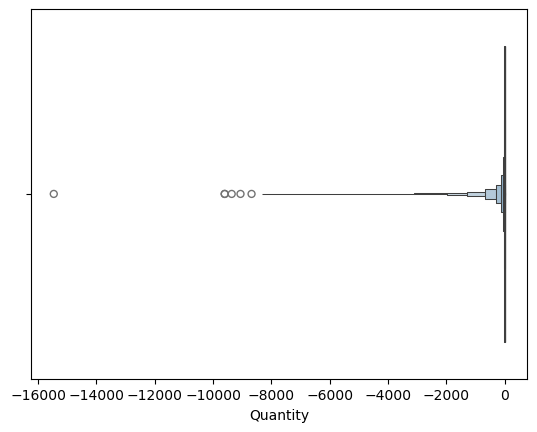

In [25]:
sns.boxenplot(
    data = df[df["Quantity"] < 0],
    x = "Quantity"
)

In [26]:
df[df["Quantity"]==df["Quantity"].min()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-15459,2011-12-09 09:27:00,2.08,16446,United Kingdom,2011-12-09,2011-12


In [27]:
df.loc[df["Quantity"] < 0 , "Country"].value_counts(normalize=True).head(10)

Country
United Kingdom    0.863515
Germany           0.043266
EIRE              0.028749
France            0.014231
USA               0.010697
Australia         0.007068
Spain             0.004585
Italy             0.004202
Belgium           0.003629
Japan             0.003534
Name: proportion, dtype: Float64

In [28]:
prop_negative_qty_by_year_month = (
    df
    .query("Quantity < 0", engine="python")["year_month"]
    .value_counts(normalize=True)
    .reset_index()
    .sort_values(by="year_month", ascending=True)
)

prop_negative_qty_by_year_month

,year_month,proportion
7,2010-12,0.075263
6,2011-01,0.076027
11,2011-02,0.046896
3,2011-03,0.078892
8,2011-04,0.070869
9,2011-05,0.068863
4,2011-06,0.076791
5,2011-07,0.076122
10,2011-08,0.066667
2,2011-09,0.085100


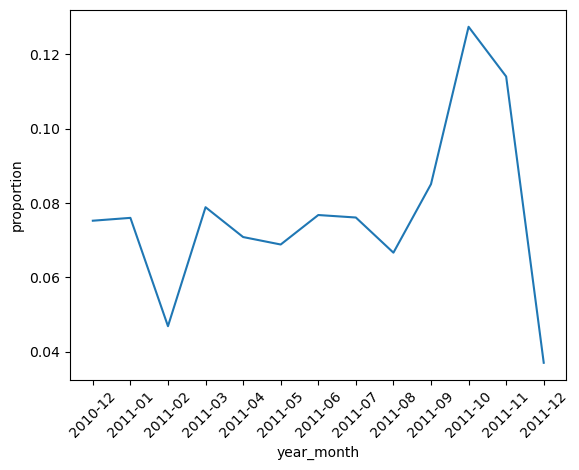

In [29]:
sns.lineplot(
    data = prop_negative_qty_by_year_month,
    x = "year_month",
    y = "proportion"
)

plt.xticks(rotation=45)

plt.show()

> The proportion of transaction with negative quantity increased significantly on September to November 2011.

We should ask related team with this issue, ex:(Operational, IT, etc.)

In [30]:
df[df["Quantity"]<0].shape[0]/df.shape[0]*100

1.932625749884633

> Only 2% of data contain negative quantity, which very small amount

#### Drop row with negative quantity

In [31]:
df = df[df["Quantity"] > 0]

df[df["Quantity"] < 0].shape

(0, 10)

### Negative unit price

In [32]:
df[df["UnitPrice"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month


> Rows with negative unit price are all with stock code = B, wich already dropped

### Missing customerid

Assumptions:
- Customer ID are missing because they weren't registered as a member

In [33]:
df.loc[df["CustomerID"].isnull(), "Country"].value_counts(normalize=True)

Country
United Kingdom    0.989352
EIRE              0.004919
Hong Kong          0.00213
Unspecified       0.001515
Switzerland       0.000937
France            0.000495
Israel            0.000352
Portugal          0.000292
Bahrain           0.000007
Name: proportion, dtype: Float64

In [34]:
df.query("CustomerID.isnull() and Country=='United Kingdom'").shape[0]/df.query("Country == 'United Kingdom'").shape[0]

0.2713163788015571

In [35]:
df[df["CustomerID"].isnull()].shape[0]/df.shape[0]

0.2510088842041861

Problem:
- 98% of data with missing CustomerID are coming from UK
- 27% data from UK don't have CustomerID
- 25% of all data don't have CustomerID

In [36]:
invoiceNo_w_null_CID = df.loc[df["CustomerID"].isnull(), "InvoiceNo"].unique().tolist()
len(invoiceNo_w_null_CID)

2187

In [37]:
stock_code_w_null_CI = df.query("InvoiceNo.isin(@invoiceNo_w_null_CID)")["StockCode"].value_counts().to_frame("null_count").reset_index()
stock_code_w_null_CI

,StockCode,null_count
0,DOT,693
1,85099B,497
2,21931,414
3,22411,387
4,20712,372
...,...,...
3536,79062D,1
3537,84795C,1
3538,90036D,1
3539,47589,1


In [38]:
df[df["StockCode"].isin(stock_code_w_null_CI.sort_values("null_count", ascending=False).head(10)["StockCode"])].groupby("StockCode")["Description"].unique()

StockCode
20712               [JUMBO BAG WOODLAND ANIMALS]
21731            [RED TOADSTOOL LED NIGHT LIGHT]
21931                   [JUMBO STORAGE BAG SUKI]
21935                       [SUKI  SHOULDER BAG]
22197     [SMALL POPCORN HOLDER, POPCORN HOLDER]
22379                 [RECYCLING BAG RETROSPOT ]
22386                  [JUMBO BAG PINK POLKADOT]
22411        [JUMBO SHOPPER VINTAGE RED PAISLEY]
85099B                 [JUMBO BAG RED RETROSPOT]
DOT                       [DOTCOM POSTAGE, <NA>]
Name: Description, dtype: object

Findings:
- The analysis above used to find out whether there are any pattern on invoice number with emptly customer id
- Interestingly, most of items transacted with condition metioned above are bags

In [39]:
pd.merge(
    stock_code_w_null_CI,
    (df.loc[
            df["StockCode"]
            .isin(stock_code_w_null_CI["StockCode"]), 
            "StockCode"
        ].value_counts().to_frame("all_data")
        .reset_index()
    ),
    on="StockCode",
    how="inner"
).eval(
    "null_pct = null_count/all_data",
    engine="python"
).sort_values(["null_count", "null_pct"], ascending=False)

,StockCode,null_count,all_data,null_pct
0,DOT,693,709,0.977433
1,85099B,497,2115,0.234988
2,21931,414,1197,0.345865
3,22411,387,1190,0.32521
4,20712,372,869,0.428078
...,...,...,...,...
3244,22708,1,100,0.01
3271,22047,1,108,0.009259
3266,22986,1,155,0.006452
3472,22704,1,175,0.005714


- ~98% of the transaction with stock code = DOT are made by non-registered customers

In [40]:
df.loc[df["StockCode"] == "DOT", "Description"].unique()

<StringArray>
['DOTCOM POSTAGE', <NA>]
Length: 2, dtype: string

In [41]:
df.loc[(df["StockCode"] == "DOT") & (df["CustomerID"].isna()), "Country"].value_counts()

Country
United Kingdom    693
Name: count, dtype: Int64

- All tansactions of stock code DOT with non-registered customers were coming from UK

In [42]:
prop_trans_dot_non_reg_cust_by_year_month = (
    df.loc[(df["StockCode"] == "DOT") & (df["CustomerID"].isna()), "year_month"]
    .value_counts(normalize=True)
    .reset_index()
    .sort_values(by="year_month", ascending=True)
)

prop_trans_dot_non_reg_cust_by_year_month

,year_month,proportion
6,2010-12,0.077922
4,2011-01,0.088023
5,2011-02,0.085137
2,2011-03,0.096681
7,2011-04,0.067821
3,2011-05,0.096681
0,2011-06,0.121212
1,2011-07,0.115440
11,2011-08,0.050505
9,2011-09,0.060606


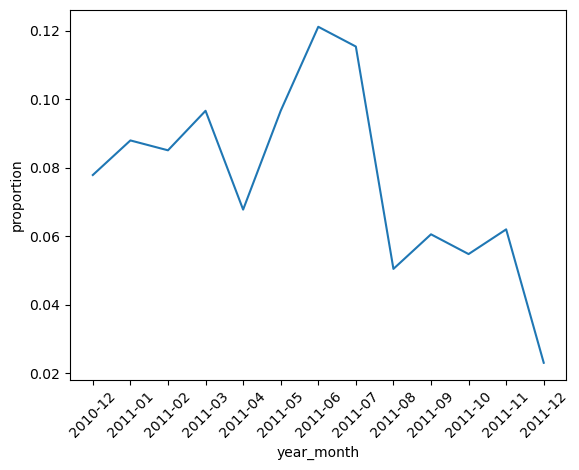

In [43]:
sns.lineplot(
    data = prop_trans_dot_non_reg_cust_by_year_month,
    x = "year_month",
    y = "proportion"
)

plt.xticks(rotation=45)

plt.show()

Decision:
- Leave observations with null customer id as is

### Unit Price 0

In [44]:
df[df["UnitPrice"]==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
30644,538877,22112,CHOCOLATE HOT WATER BOTTLE,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30657,538877,22356,CHARLOTTE BAG PINK POLKADOT,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30555,538873,22734,amazon sales,20,2010-12-14 15:13:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30603,538877,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-14 15:29:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
30364,538861,22444,<NA>,460,2010-12-14 14:04:00,0.0,<NA>,United Kingdom,2010-12-14,2010-12
...,...,...,...,...,...,...,...,...,...,...
524622,580609,22927,Amazon,1,2011-12-05 11:41:00,0.0,<NA>,United Kingdom,2011-12-05,2011-12
524375,580549,84876B,found,66,2011-12-05 09:54:00,0.0,<NA>,United Kingdom,2011-12-05,2011-12
524475,580588,21808,<NA>,5,2011-12-05 10:35:00,0.0,<NA>,United Kingdom,2011-12-05,2011-12
524474,580586,21804,dotcom,4,2011-12-05 10:34:00,0.0,<NA>,United Kingdom,2011-12-05,2011-12


In [45]:
df.loc[df["UnitPrice"]==0, "CustomerID"].isna().sum()

1139

98% of observations with unit price = 0 also have missing value on customer id

In [46]:
df.query("UnitPrice==0 and CustomerID.isnull()", engine="python")["Country"].value_counts()

Country
United Kingdom    1137
EIRE                 2
Name: count, dtype: Int64

99% of observations of unit price = 0 and missing customer id are happened in UK

#### Drop rows with Unit price of 0

In [47]:
df = df[df["UnitPrice"] != 0]

df[df["UnitPrice"]==0].shape

(0, 10)

### Synchronize stock with multiple descriptions

In [48]:
invoice_stock_w_multiple_description

,StockCode,InvoiceNo,unique_desc_count
0,23203,575335,2
1,23298,554084,2


In [49]:
invoice_stock_w_synchronized_description = (
    df
    .merge(
        invoice_stock_w_multiple_description,
        on = ["StockCode", "InvoiceNo"],
        how = "inner"
    )
    .groupby([
        "StockCode", "InvoiceNo", "Quantity", "InvoiceTimestamp", "UnitPrice", 
        "CustomerID", "Country", "InvoiceDate",	"year_month"
    ])
    .agg(
        Description = pd.NamedAgg("Description", "first")
    )
    .reset_index()
)

invoice_stock_w_synchronized_description

,StockCode,InvoiceNo,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month,Description
0,23203,575335,300,2011-11-09 13:56:00,1.79,12931,United Kingdom,2011-11-09,2011-11,JUMBO BAG DOILEY PATTERNS
1,23298,554084,3,2011-05-22 11:52:00,4.95,12909,United Kingdom,2011-05-22,2011-05,SPOTTY BUNTING


In [50]:
df = (
    pd.concat(
        [
            df
            .merge(
                invoice_stock_w_synchronized_description[["StockCode", "InvoiceNo"]],
                on = ["StockCode", "InvoiceNo"],
                how = "left",
                indicator = True
            )
            .query("_merge == 'left_only'")
            .drop(columns=["_merge"]),
            invoice_stock_w_synchronized_description
        ],
        axis = 0,
        ignore_index = True
    )
)

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12
1,538635,17021,NAMASTE SWAGAT INCENSE,12,2010-12-13 13:32:00,0.3,17303,United Kingdom,2010-12-13,2010-12
2,538635,85018D,YULETIDE IMAGES S/6 PAPER BOXES,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
3,538635,22412,METAL SIGN NEIGHBOURHOOD WITCH,1,2010-12-13 13:32:00,2.1,17303,United Kingdom,2010-12-13,2010-12
4,538635,22640,SET OF 4 NAPKIN CHARMS 3 KEYS,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
...,...,...,...,...,...,...,...,...,...,...
530094,580610,85099B,JUMBO BAG RED RETROSPOT,4,2011-12-05 11:48:00,4.13,<NA>,United Kingdom,2011-12-05,2011-12
530095,580610,85049a,TRADITIONAL CHRISTMAS RIBBONS,11,2011-12-05 11:48:00,3.29,<NA>,United Kingdom,2011-12-05,2011-12
530096,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,2011-12-09,2011-12
530097,575335,23203,JUMBO BAG DOILEY PATTERNS,300,2011-11-09 13:56:00,1.79,12931,United Kingdom,2011-11-09,2011-11


### Duplicated invoice no & stock code

In [51]:
multiple_invoice_stockCode_pair = (
    df
    .groupby(["InvoiceNo", "StockCode"])
    .size().to_frame("size")
    .sort_values(by="size", ascending=False)
    .query("size>1")
    .reset_index()
)

multiple_invoice_stockCode_pair

,InvoiceNo,StockCode,size
0,555524,22698,20
1,555524,22697,12
2,572861,22775,8
3,578289,23395,7
4,572344,M,7
...,...,...,...
9559,581149,21446,2
9560,547664,22241,2
9561,571883,22907,2
9562,560555,22457,2


In [52]:
(
    df
    .groupby(["InvoiceNo", "StockCode", "Country"])
    .size().to_frame("size")
    .sort_values(by="size", ascending=False)
    .query("size>1")
    .reset_index()
    .loc[lambda x: x.duplicated(subset=["InvoiceNo", "StockCode"])]
)

,InvoiceNo,StockCode,Country,size


In [53]:
df.query(
    "(InvoiceNo==@multiple_invoice_stockCode_pair.head(1)['InvoiceNo'].values[0])\
    & (StockCode==@multiple_invoice_stockCode_pair.head(1)['StockCode'].values[0])", 
    engine="python"
)

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
229525,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229526,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229529,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229530,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229531,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229532,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229533,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229534,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229535,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06
229536,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2011-06-05,2011-06


In [54]:
invoice_stock_w_multiple_invoice_time

,InvoiceNo,StockCode,invoice_time_count
0,541596,22748,2
1,541809,21929,2
2,544186,21094,2
3,550320,22839,2
4,567183,22659,2
5,567183,22907,2
6,578548,84347,2


Problem:
- The samples above showing a pair of invoice number and stock code.
- Values across all columns are the same, why these data didn't grouped as one and the quantity summed?
- There are 9,694 pairs of invoice number and stock code infected with the problem
- There are 6 pairs of InvoiceNo and StockCode with multiple invoice timestamp

Assumptions:
- These pairs weren't grouped as one due to manual entry or system error

Resolves:
- synchronize invoice timestamp for pairs of invoice number with stock code
    - use min timestamp value
- aggregate these rows into one pair of invoce number and stock code

#### Synchronize invoice timestamp for pairs of invoice number with stock code

In [55]:
df_invoice_stock_w_multiple_invoice_time = (
    df
    .groupby(["InvoiceNo", "StockCode"])["InvoiceTimestamp"]
    .min()
    .reset_index()
    .merge(
        invoice_stock_w_multiple_invoice_time[["InvoiceNo", "StockCode"]],
        on = ["InvoiceNo", "StockCode"],
        how = "right"
    )
)

df_invoice_stock_w_multiple_invoice_time

,InvoiceNo,StockCode,InvoiceTimestamp
0,541596,22748,2011-01-19 16:18:00
1,541809,21929,2011-01-21 14:58:00
2,544186,21094,2011-02-16 15:55:00
3,550320,22839,2011-04-17 12:37:00
4,567183,22659,2011-09-18 15:32:00
5,567183,22907,2011-09-18 15:32:00
6,578548,84347,2011-11-24 15:02:00


In [56]:
df_multiple_invoice_time_synchronized = (
    df
    .drop(columns=["InvoiceTimestamp"])
    .merge(df_invoice_stock_w_multiple_invoice_time, on=["InvoiceNo", "StockCode"], how="inner")
)

df_multiple_invoice_time_synchronized

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDate,year_month,InvoiceTimestamp
0,541809,21929,JUMBO BAG PINK VINTAGE PAISLEY,2,4.13,<NA>,United Kingdom,2011-01-21,2011-01,2011-01-21 14:58:00
1,541809,21929,JUMBO BAG PINK VINTAGE PAISLEY,2,4.96,<NA>,United Kingdom,2011-01-21,2011-01,2011-01-21 14:58:00
2,541596,22748,POPPY'S PLAYHOUSE KITCHEN,1,2.1,17602,United Kingdom,2011-01-19,2011-01,2011-01-19 16:18:00
3,541596,22748,POPPY'S PLAYHOUSE KITCHEN,3,2.1,17602,United Kingdom,2011-01-19,2011-01,2011-01-19 16:18:00
4,544186,21094,SET/6 RED SPOTTY PAPER PLATES,6,0.85,<NA>,United Kingdom,2011-02-16,2011-02,2011-02-16 15:55:00
5,544186,21094,SET/6 RED SPOTTY PAPER PLATES,2,0.83,<NA>,United Kingdom,2011-02-16,2011-02,2011-02-16 15:55:00
6,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,2,14.95,12748,United Kingdom,2011-04-17,2011-04,2011-04-17 12:37:00
7,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,1,14.95,12748,United Kingdom,2011-04-17,2011-04,2011-04-17 12:37:00
8,567183,22907,PACK OF 20 NAPKINS PANTRY DESIGN,6,0.85,14769,United Kingdom,2011-09-18,2011-09,2011-09-18 15:32:00
9,567183,22659,LUNCH BOX I LOVE LONDON,2,1.95,14769,United Kingdom,2011-09-18,2011-09,2011-09-18 15:32:00


In [57]:
df = pd.concat(
    [
        df.merge(
            df_multiple_invoice_time_synchronized[["InvoiceNo", "StockCode"]],
            on = ["InvoiceNo", "StockCode"],
            how = "left",
            indicator = True
        ).query("_merge == 'left_only'").drop(columns=["_merge"]),
        df_multiple_invoice_time_synchronized
    ],
    axis = 0
)

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12
1,538635,17021,NAMASTE SWAGAT INCENSE,12,2010-12-13 13:32:00,0.3,17303,United Kingdom,2010-12-13,2010-12
2,538635,85018D,YULETIDE IMAGES S/6 PAPER BOXES,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
3,538635,22412,METAL SIGN NEIGHBOURHOOD WITCH,1,2010-12-13 13:32:00,2.1,17303,United Kingdom,2010-12-13,2010-12
4,538635,22640,SET OF 4 NAPKIN CHARMS 3 KEYS,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
...,...,...,...,...,...,...,...,...,...,...
10,567183,22907,PACK OF 20 NAPKINS PANTRY DESIGN,8,2011-09-18 15:32:00,0.85,14769,United Kingdom,2011-09-18,2011-09
11,567183,22659,LUNCH BOX I LOVE LONDON,2,2011-09-18 15:32:00,1.95,14769,United Kingdom,2011-09-18,2011-09
12,578548,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1,2011-11-24 15:02:00,2.55,17345,United Kingdom,2011-11-24,2011-11
13,578548,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3,2011-11-24 15:02:00,2.55,17345,United Kingdom,2011-11-24,2011-11


#### Aggregate quantity of duplicated rows by invoice number and stock code

In [58]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceTimestamp',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate', 'year_month'],
      dtype='object')

In [59]:
df = pd.concat(
    [
        df.merge(
            multiple_invoice_stockCode_pair[["InvoiceNo", "StockCode"]],
            on = ["InvoiceNo", "StockCode"],
            how = "left",
            indicator = True
        )
        .query("_merge == 'left_only'")
        .drop(columns=["_merge"]),
        multiple_invoice_stockCode_pair[["InvoiceNo", "StockCode"]]
        .merge(
            df,
            on = ["InvoiceNo", "StockCode"],
            how = "left"
        )
        .groupby(
            ["InvoiceNo", "StockCode", "Description", "InvoiceTimestamp", 
            "UnitPrice", "CustomerID", "Country", "InvoiceDate", "year_month"]
        )
        .agg(
            Quantity = pd.NamedAgg("Quantity", "sum")
        )
        .reset_index()
    ],
    axis = 0,
    ignore_index = True
)


df

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12
1,538635,17021,NAMASTE SWAGAT INCENSE,12,2010-12-13 13:32:00,0.3,17303,United Kingdom,2010-12-13,2010-12
2,538635,85018D,YULETIDE IMAGES S/6 PAPER BOXES,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
3,538635,22412,METAL SIGN NEIGHBOURHOOD WITCH,1,2010-12-13 13:32:00,2.1,17303,United Kingdom,2010-12-13,2010-12
4,538635,22640,SET OF 4 NAPKIN CHARMS 3 KEYS,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12
...,...,...,...,...,...,...,...,...,...,...
519234,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,2,2011-12-09 11:34:00,2.49,14446,United Kingdom,2011-12-09,2011-12
519235,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,2,2011-12-09 11:34:00,2.08,14446,United Kingdom,2011-12-09,2011-12
519236,581538,23349,ROLL WRAP VINTAGE CHRISTMAS,4,2011-12-09 11:34:00,1.25,14446,United Kingdom,2011-12-09,2011-12
519237,581538,35004B,SET OF 3 BLACK FLYING DUCKS,3,2011-12-09 11:34:00,5.45,14446,United Kingdom,2011-12-09,2011-12


# Analysis

Business Questions:
- Top 5 Country with most transaction
- Top 5 basket size by country
- Top 5 basket value by country
- MoM sales growth
- What's top 10 product transacted in terms of frequency?
- What's top 5 Countries that generate most revenue?
- Top 5 product with most revenue

## Top 5 countries by transaction

> counted by frequency of unique invoice no, since 1 invoiceno has multiple stock code

In [60]:
top5_countries_by_transaction = (
    df
    .groupby("Country")
    .agg(
        transaction_freq = pd.NamedAgg("InvoiceNo", "nunique")
    )
    .reset_index()
    .sort_values(by="transaction_freq", ascending=False)
    .head()
)

top5_countries_by_transaction

,Country,transaction_freq
36,United Kingdom,18015
14,Germany,457
13,France,392
10,EIRE,287
3,Belgium,98


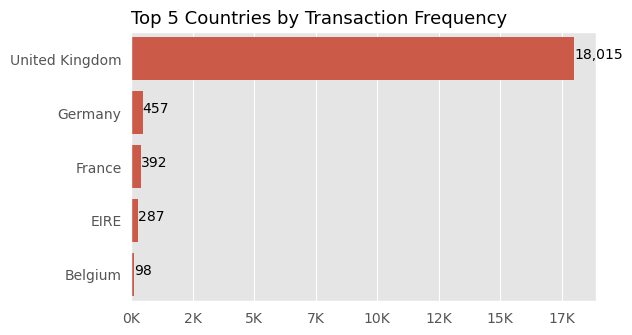

In [112]:
fig, ax = plt.subplots(figsize=(6, 3.5))

sns.barplot(
    top5_countries_by_transaction,
    y = "Country",
    x = "transaction_freq",
    ax = ax
)

ax.set_ylabel(None)
ax.set_xlabel(None)

for idx, val in enumerate(top5_countries_by_transaction["transaction_freq"]):
    formatted_val = "{:,}".format(val)
    plt.text(val, idx, formatted_val)

ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1e3)}K"))

ax.set_title(
    "Top 5 Countries by Transaction Frequency", 
    loc = "left",
    size = 13
)

ax.tick_params(
    left = None,
    bottom = None
)

plt.show()

## Top 5 Countries by Revenue

In [64]:
df["revenue"] = df["Quantity"] * df["UnitPrice"]

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceTimestamp,UnitPrice,CustomerID,Country,InvoiceDate,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12,15.3
1,538635,17021,NAMASTE SWAGAT INCENSE,12,2010-12-13 13:32:00,0.3,17303,United Kingdom,2010-12-13,2010-12,3.6
2,538635,85018D,YULETIDE IMAGES S/6 PAPER BOXES,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12,2.55
3,538635,22412,METAL SIGN NEIGHBOURHOOD WITCH,1,2010-12-13 13:32:00,2.1,17303,United Kingdom,2010-12-13,2010-12,2.1
4,538635,22640,SET OF 4 NAPKIN CHARMS 3 KEYS,1,2010-12-13 13:32:00,2.55,17303,United Kingdom,2010-12-13,2010-12,2.55
...,...,...,...,...,...,...,...,...,...,...,...
519234,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,2,2011-12-09 11:34:00,2.49,14446,United Kingdom,2011-12-09,2011-12,4.98
519235,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,2,2011-12-09 11:34:00,2.08,14446,United Kingdom,2011-12-09,2011-12,4.16
519236,581538,23349,ROLL WRAP VINTAGE CHRISTMAS,4,2011-12-09 11:34:00,1.25,14446,United Kingdom,2011-12-09,2011-12,5.0
519237,581538,35004B,SET OF 3 BLACK FLYING DUCKS,3,2011-12-09 11:34:00,5.45,14446,United Kingdom,2011-12-09,2011-12,16.35


In [65]:
top5_country_by_revenue = df.groupby("Country").agg(
    total_revenue = pd.NamedAgg("revenue", "sum")
).sort_values("total_revenue", ascending=False).reset_index().head()

top5_country_by_revenue

,Country,total_revenue
0,United Kingdom,8790616.934
1,Netherlands,285446.34
2,EIRE,280221.24
3,Germany,228867.14
4,France,209715.11


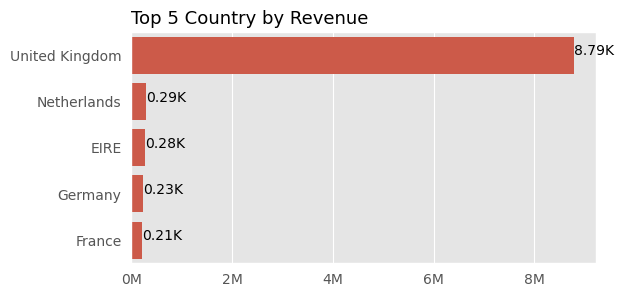

In [115]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=top5_country_by_revenue,
    x="total_revenue",
    y="Country",
    ax=ax
)

ax.set_title(
    "Top 5 Country by Revenue",
    loc = "left",
    size = 13
)

for idx, total_revenue in enumerate(top5_country_by_revenue["total_revenue"].values):
    formatted_total_revenue = f"{'{:.2f}'.format(total_revenue/1e6)}K"
    plt.text(total_revenue, idx, formatted_total_revenue)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1e6)}M"))

ax.tick_params(
    left = None,
    bottom = None
)

plt.show()

## Basket Size

$$
\text{basket size} = \frac{\sum{\text{quantity}}}{\sum{\text{transaction}}}
$$

In [ ]:
basket_size = df.groupby("Country").agg(
    sum_quantity = pd.NamedAgg("Quantity", "sum"),
    sum_transaction = pd.NamedAgg("InvoiceNo", "nunique"),
).reset_index()

basket_size["basket_size"] = basket_size["sum_quantity"]/basket_size["sum_transaction"]

basket_size = pd.merge(
    left=basket_size,
    right=df.groupby(by=["Country", "InvoiceNo"]).agg(
            total_revenue = pd.NamedAgg("revenue", "sum")
        ).reset_index().groupby("Country").agg(
            avg_revenue_per_transaction = pd.NamedAgg("total_revenue", "mean")
        ).reset_index()[["Country", "avg_revenue_per_transaction"]],
    how="inner",
    on="Country"
).round({
    "basket_size": 0, 
    "avg_revenue_per_transaction": 0
}).sort_values("basket_size", ascending=False)

In [ ]:
basket_size.head()

- Altough UK has the most proportion of transaction, Netherland generates highest basket size with avg of revenue per transaction is 3 grands

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=basket_size.head(),
    x="basket_size",
    y="Country",
    ax=ax
)

ax.set_title("Top 5 Basket Size\nby Country", loc="left")
ax.set_ylabel(None)
ax.set_xlabel("Basket Size")

ax.spines[["left", "top", "right"]].set_visible(None)
ax.tick_params(
    left = None
)

plt.show()

## Basket Value

$$
\text{basket value} = \frac{\sum{\text{revenue}}}{\sum{\text{transaction}}}
$$

In [ ]:
basket_value = df.groupby("Country").agg(
    total_revenue = pd.NamedAgg("revenue", "sum"),
    total_transaction = pd.NamedAgg("InvoiceNo", "nunique")
).reset_index()

basket_value["basket_value"] = np.round(
    basket_value["total_revenue"]/basket_value["total_transaction"], 
    0
)
basket_value = basket_value.sort_values(by="basket_value", ascending=False)

basket_value

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=basket_value.head(),
    y="Country",
    x="basket_value",
    ax=ax
)

ax.set_title("Top 5 Basket Value\nby Country", loc="left")
ax.set_ylabel(None)
ax.set_xlabel("Basket Value")

ax.tick_params(
    left = None
)
ax.spines[["left", "top", "right"]].set_visible(False)

plt.show()

## MoM Sales Growth

$$
\text{MoM Sales Growth} = \frac{\sum{\text{sales of current month}}- \sum{\text{sales of previous month}}}{\sum{\text{sales of previous month}}}
$$

In [ ]:
mom_sales_growth = df.set_index("InvoiceDate").groupby(pd.Grouper(freq="ME")).agg(
    total_sales = pd.NamedAgg("revenue", "sum"),
    total_item_sold = pd.NamedAgg("Quantity", "sum")
)

mom_sales_growth["mom_sales_growth"] = (mom_sales_growth["total_sales"]-mom_sales_growth["total_sales"].shift(periods=1))/mom_sales_growth["total_sales"].shift(periods=1)

mom_sales_growth = mom_sales_growth.reset_index()
mom_sales_growth["period"] = pd.Categorical(
    mom_sales_growth["InvoiceDate"].dt.to_period("M").dt.strftime("%Y-%m"),
    categories=['2010-12', '2011-01', '2011-02', 
                '2011-03', '2011-04', '2011-05', 
                '2011-06', '2011-07', '2011-08', 
                '2011-09', '2011-10', '2011-11', 
                '2011-12'],
    ordered=True
)
mom_sales_growth

In [ ]:
mom_sales_growth2 = mom_sales_growth.copy()
mom_sales_growth2["period"] = mom_sales_growth.dropna()["period"].cat.remove_unused_categories()
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=mom_sales_growth2,
    x="period",
    y="mom_sales_growth",
    ax=ax
)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.set_title("MoM Sales Growth")
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.spines[["top", "right"]].set_visible(False)

plt.show()

del mom_sales_growth2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    data=mom_sales_growth,
    x="period",
    y="total_item_sold",
    ax=ax
)

ax.set_title("Sum of Quantity Sold over the Period")
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_ybound(0, 700000)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

> 

In [ ]:
df["InvoiceTimestamp"].dt.to_period("M").dt.strftime("%Y-%m")

In [ ]:
df["Country"].unique().tolist()

In [ ]:
revenue_df = df.groupby(by=["InvoiceDate", "Country"]).agg(total_revenue = pd.NamedAgg("revenue", "sum")).reset_index()
revenue_df.head()

In [ ]:
sns.lineplot(
    data = df.groupby("InvoiceDate").agg(total_revenue = pd.NamedAgg("revenue", "sum")),
    x = "InvoiceDate",
    y = "total_revenue"
)